# Webscraping Craigslist for Housing Listings in the East Bay

### Jennifer Jones

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup as bs4

Populating the interactive namespace from numpy and matplotlib


## Craigslist houses for sale

Look on the Craigslist website, select relevant search criteria, and then take a look at the web address:

Houses for sale in the East Bay:  
[http://sfbay.craigslist.org/search/eby/rea?housing_type=6](http://sfbay.craigslist.org/search/eby/rea?housing_type=6)

Houses for sale in selected neighborhoods in the East Bay:  
[http://sfbay.craigslist.org/search/eby/rea?nh=46&nh=47&nh=48&nh=49&nh=112&nh=54&nh=55&nh=60&nh=62&nh=63&nh=66&housing_type=6](http://sfbay.craigslist.org/search/eby/rea?nh=46&nh=47&nh=48&nh=49&nh=112&nh=54&nh=55&nh=60&nh=62&nh=63&nh=66&housing_type=6) 


## General Procedure

```python

# Get the data using the requests module 
url = 'http://sfbay.craigslist.org/search/eby/rea?housing_type=6'
resp = requests.get(url) 

# BeautifulSoup can quickly parse the text, specify text is html
txt = bs4(resp.text, 'html.parser')

```

## House entries

Looked through output via `print(txt.prettify())` to display the html in a more readable way, to note the structure of housing listings

Saw housing entries contained in `<p class="row">`

`houses = txt.find_all('p', attrs={'class': 'row'})`


## Get data from multiple pages on Craigslist


First page:  
url = 'http://sfbay.craigslist.org/search/eby/rea?housing_type=6'

For multiple pages, the pattern is:  
http://sfbay.craigslist.org/search/eby/rea?s=100&housing_type=6  
http://sfbay.craigslist.org/search/eby/rea?s=200&housing_type=6  
etc.

In [3]:
# Get the data using the requests module 
npgs = np.arange(0,10,1)
npg = 100

base_url = 'http://sfbay.craigslist.org/search/eby/rea?'
urls = [base_url + 'housing_type=6']

for pg in range(len(npgs)):
    url = base_url + 's=' + str(npg) + '&housing_type=6'
    urls.append(url)
    npg += 100

more_reqs = []
for p in range(len(npgs)+1):
    more_req = requests.get(urls[p]) 
    more_reqs.append(more_req)

In [6]:
print(urls)

['http://sfbay.craigslist.org/search/eby/rea?housing_type=6', 'http://sfbay.craigslist.org/search/eby/rea?s=100&housing_type=6', 'http://sfbay.craigslist.org/search/eby/rea?s=200&housing_type=6', 'http://sfbay.craigslist.org/search/eby/rea?s=300&housing_type=6', 'http://sfbay.craigslist.org/search/eby/rea?s=400&housing_type=6', 'http://sfbay.craigslist.org/search/eby/rea?s=500&housing_type=6', 'http://sfbay.craigslist.org/search/eby/rea?s=600&housing_type=6', 'http://sfbay.craigslist.org/search/eby/rea?s=700&housing_type=6', 'http://sfbay.craigslist.org/search/eby/rea?s=800&housing_type=6', 'http://sfbay.craigslist.org/search/eby/rea?s=900&housing_type=6', 'http://sfbay.craigslist.org/search/eby/rea?s=1000&housing_type=6']


In [7]:
# USe BeautifulSoup to parse the text
more_txts = []
for p in range(len(npgs)+1):
    more_txt = bs4(more_reqs[p].text, 'html.parser')
    more_txts.append(more_txt)

# Save the housing entries to a list
more_houses = [more_txts[h].findAll(attrs={'class': "row"}) for h in range(len(more_txts))] 
print(len(more_houses))
print(len(more_houses[0]))

11
100


In [8]:
# Make a list of housing entries from all of the pages of data
npg = len(more_houses)

houses_all = [] 
for n in range(npg):
    houses_all.extend(more_houses[n])
print(len(houses_all))

1100


# Extract and clean data to put in a database

In [9]:
# Define 4 functions for the price, neighborhood, sq footage & # bedrooms, and time
# that can deal with missing values (to prevent errors from showing up when running the code)

# Prices
def find_prices(results):
    prices = []
    for rw in results:
        price = rw.find('span', {'class': 'price'})
        if price is not None:
            price = float(price.text.strip('$'))
        else:
            price = np.nan
        prices.append(price)
    return prices

# Define a function for neighborhood in case a field is missing in 'class': 'pnr'
def find_neighborhood(results):
    neighborhoods = []
    for rw in results:
        split = rw.find('span', {'class': 'pnr'}).text.strip(' (').split(')')
        #split = rw.find(attrs={'class': 'pnr'}).text.strip(' (').split(')')
        if len(split) == 2:
            neighborhood = split[0]
        elif 'pic map' or 'pic' or 'map' in split[0]:
            neighborhood = np.nan
        neighborhoods.append(neighborhood)
    return neighborhoods

# Make a function to deal with size in case #br or ft2 is missing
def find_size_and_brs(results):
    sqft = []
    bedrooms = []
    for rw in results:
        split = rw.find('span', attrs={'class': 'housing'})
        # If the field doesn't exist altogether in a housing entry
        if split is not None:
        #if rw.find('span', {'class': 'housing'}) is not None:
            # Removes leading and trailing spaces and dashes, splits br & ft
            #split = rw.find('span', attrs={'class': 'housing'}).text.strip('/- ').split(' - ')
            split = split.text.strip('/- ').split(' - ')
            if len(split) == 2:
                n_brs = split[0].replace('br', '')
                size = split[1].replace('ft2', '')
            elif 'br' in split[0]: # in case 'size' field is missing
                n_brs = split[0].replace('br', '')
                size = np.nan
            elif 'ft2' in split[0]: # in case 'br' field is missing
                size = split[0].replace('ft2', '')
                n_brs = np.nan
        else:
            size = np.nan
            n_brs = np.nan
        sqft.append(float(size))
        bedrooms.append(float(n_brs))
    return sqft, bedrooms

# Time posted
def find_times(results):
    times = []
    for rw in results:
        time = rw.findAll(attrs={'class': 'pl'})[0].time['datetime']
        if time is not None:
            time# = time
        else:
            time = np.nan
        times.append(time)
    return pd.to_datetime(times)

In [10]:
# Apply functions to data to extract useful information
prices_all = find_prices(houses_all)
neighborhoods_all = find_neighborhood(houses_all) 
sqft_all, bedrooms_all = find_size_and_brs(houses_all)
times_all = find_times(houses_all)

# Check
print(len(prices_all))
#print(len(neighborhoods_all))
#print(len(sqft_all))
#print(len(bedrooms_all))
#print(len(times_all))

1100


## Add data to pandas database

In [47]:
# Make a dataframe to export cleaned data
data = np.array([sqft_all, bedrooms_all, prices_all]).T
print(data.shape)

(1100, 3)


In [48]:
alldata = pd.DataFrame(data = data, columns = ['SqFeet', 'nBedrooms', 'Price'])
alldata.head(4)

,SqFeet,nBedrooms,Price
0,1890,4,539999
1,NaN,4,499950
2,3288,5,609000
3,1200,3,635000


In [49]:
alldata['DatePosted'] = times_all
alldata['Neighborhood'] = neighborhoods_all

In [50]:
alldata.head(4)

,SqFeet,nBedrooms,Price,DatePosted,Neighborhood
0,1890,4,539999,2016-04-08 10:02:00,hayward / castro valley
1,NaN,4,499950,2016-04-08 10:02:00,"hercules, pinole, san pablo, el sob"
2,3288,5,609000,2016-04-08 10:00:00,brentwood / oakley
3,1200,3,635000,2016-04-08 10:00:00,walnut creek


In [52]:
# Check data types
print(alldata.dtypes)
print(type(alldata.DatePosted[0]))
print(type(alldata.SqFeet[0]))
print(type(alldata.nBedrooms[0]))
print(type(alldata.Neighborhood[0]))
print(type(alldata.Price[0]))

SqFeet                 float64
nBedrooms              float64
Price                  float64
DatePosted      datetime64[ns]
Neighborhood            object
dtype: object
<class 'pandas.tslib.Timestamp'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'str'>
<class 'numpy.float64'>


In [17]:
# To change index to/from time field
# alldata.set_index('DatePosted', inplace = True)
# alldata.reset_index(inplace=True)

## Download data to csv file

In [50]:
alldata.to_csv('./webscraping_craigslist.csv', sep=',', na_rep=np.nan, header=True, index=False)


## Data for Berkeley

In [51]:
# Get houses listed in Berkeley
print(len(alldata[alldata['Neighborhood'] == 'berkeley']))
alldata[alldata['Neighborhood'] == 'berkeley']

11


,Price,SqFeet,nBedrooms,DatePosted,Neighborhood
113,849000,1438,3,2016-04-07 09:44:00,berkeley
292,1175000,2192,4,2016-04-06 13:53:00,berkeley
392,1358888,3921,5,2016-04-06 07:18:00,berkeley
415,1565000,3507,5,2016-04-06 06:49:00,berkeley
597,600000,NaN,NaN,2016-04-04 19:56:00,berkeley
655,725000,NaN,2,2016-04-04 12:51:00,berkeley
704,780000,4200,4,2016-04-04 08:12:00,berkeley
824,929000,NaN,3,2016-04-02 09:36:00,berkeley
883,545000,NaN,2,2016-04-01 16:59:00,berkeley
887,1325000,NaN,3,2016-04-01 16:47:00,berkeley


In [52]:
# Home prices in Berkeley (or the baseline)

# Choose a baseline, based on proximity to current location
# 'berkeley', 'berkeley north / hills', 'albany / el cerrito'
neighborhood_name = 'berkeley'

print('The average home price in %s is: $' %neighborhood_name, '{0:8,.0f}'.format(alldata.groupby('Neighborhood').mean().Price.ix[neighborhood_name]), '\n')
print('The most expensive home price in %s is:  $' %neighborhood_name, '{0:8,.0f}'.format(alldata.groupby('Neighborhood').max().Price.ix[neighborhood_name]), '\n')
print('The least expensive home price in %s is: $' %neighborhood_name, '{0:9,.0f}'.format(alldata.groupby('Neighborhood').min().Price.ix[neighborhood_name]), '\n')

The average home price in berkeley is: $  936,444 

The most expensive home price in berkeley is:  $ 1,565,000 

The least expensive home price in berkeley is: $   449,000 



## Scatter plots

In [20]:
# Plot house prices in the East Bay

def scatterplot(X, Y, labels, xmax): # =X.max()): # labels=[]
    
    # Set up the figure
    fig = plt.figure(figsize=(15,8)) # width, height

    fntsz=20
    titlefntsz=25
    lablsz=20
    mrkrsz=8
    matplotlib.rc('xtick', labelsize = lablsz); matplotlib.rc('ytick', labelsize = lablsz)

    # Plot a scatter plot
    ax = fig.add_subplot(111) # row column position 
    ax.plot(X,Y,'bo')

    # Grid
    ax.grid(b = True, which='major', axis='y') # which='major','both'; options/kwargs: color='r', linestyle='-', linewidth=2)

    # Format x axis
    #ax.set_xticks(range(0,len(X))); 
    ax.set_xlabel(labels[0], fontsize = titlefntsz)
    #ax.set_xticklabels(X.index, rotation='vertical') # 90, 45, 'vertical'
    ax.set_xlim(0,xmax)

    # Format y axis
    #minor_yticks  = np.arange(0, 1600000, 100000)
    #ax.set_yticks(minor_yticks, minor = True) 
    ax.set_ylabel(labels[1], fontsize = titlefntsz)
    
    # Set Title
    ax.set_title('$\mathrm{Average \; Home \; Prices \; in \; the \; East \; Bay \; (Source: Craigslist)}$', fontsize = titlefntsz)
    #fig.suptitle('Home Prices in the East Bay (Source: Craigslist)')
    
    # Save figure
    #plt.savefig("home_prices.pdf",bbox_inches='tight')

    # Return plot object
    return fig, ax


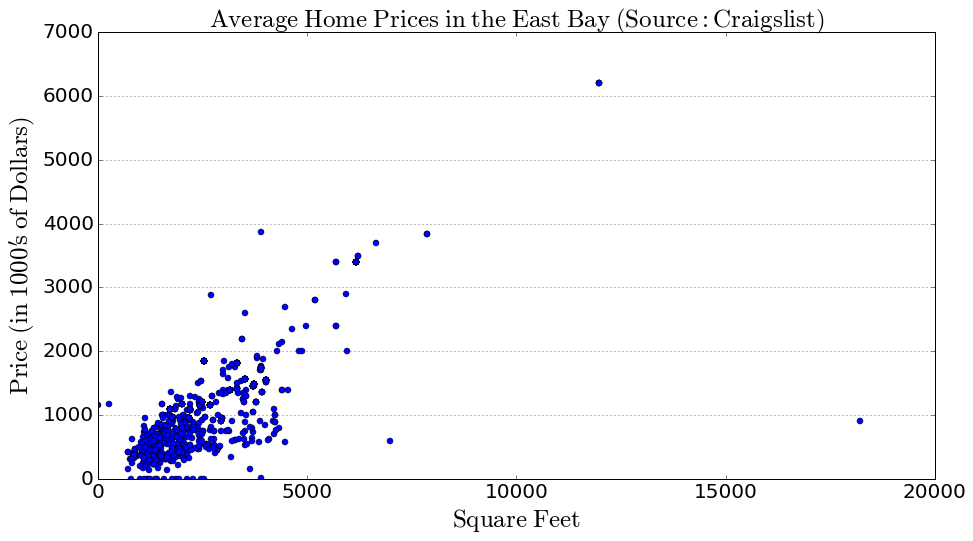

In [22]:
X = alldata.SqFeet
Y = alldata.Price/1000 # in 1000's of Dollars
labels = ['$\mathrm{Square \; Feet}$', '$\mathrm{Price \; (in \; 1000\'s \; of \; Dollars)}$']
ax = scatterplot(X,Y,labels,20000)

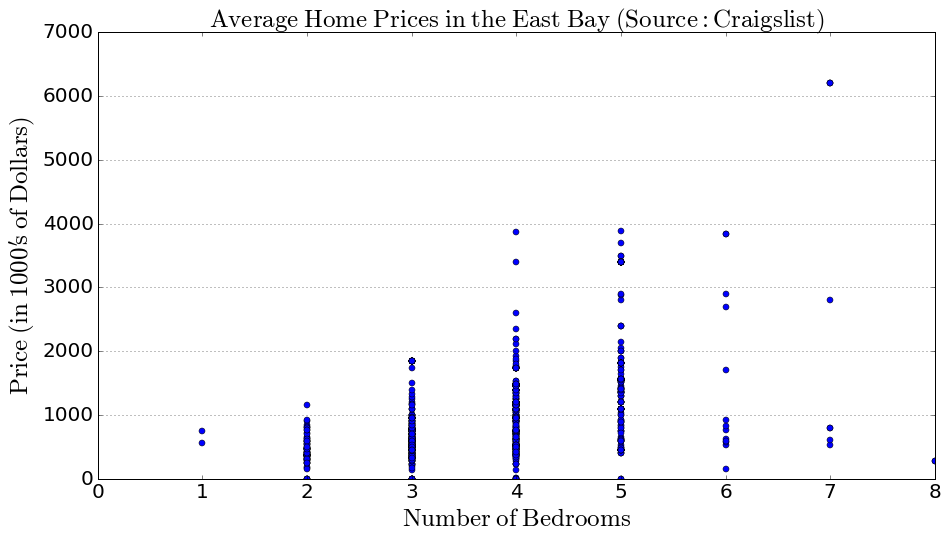

In [24]:
X = alldata.nBedrooms
Y = alldata.Price/1000 # in 1000's of Dollars
labels = ['$\mathrm{Number \; of \; Bedrooms}$', '$\mathrm{Price \; (in \; 1000\'s \; of \; Dollars)}$']
ax = scatterplot(X,Y,labels,X.max())

## Price

In [54]:
# How many houses for sale are under $700k?
price_baseline = 700000
print(alldata[(alldata.Price < price_baseline)].count())

# Return entries for houses under $700k
# alldata[(alldata.Price < price_baseline)]
# In which neighborhoods are these houses located?
set(alldata[(alldata.Price < price_baseline)].Neighborhood)


SqFeet          367
nBedrooms       421
Price           439
DatePosted      439
Neighborhood    432
dtype: int64


{'El Dorado Hills',
 nan,
 'richmond / point / annex',
 'Glorieta, NM',
 'hercules, pinole, san pablo, el sob',
 'Sonora',
 'Discovery Bay',
 'Lower Laurel District',
 '2664 Tronero Way Rancho Cordova CA',
 'albany / el cerrito',
 'oakland downtown',
 'LAS VEGAS',
 'san leandro',
 'Hesperian Gardens',
 'DAVIS',
 'pittsburg / antioch',
 'Clio/Graeagle',
 'Manteca, CA',
 'fremont / union city / newark',
 'walnut creek',
 '5448 Bloom Dr. Marysville CA',
 'brentwood / oakley',
 'oakland west',
 'vallejo / benicia',
 'berkeley north / hills',
 'oakland north / temescal',
 'oakland hills / mills',
 'Elk Grove',
 'Fernley',
 'ELK GROVE',
 'berkeley',
 'oakland lake merritt / grand',
 'sacramento',
 '8954 N. Camden Dr. Elk Grove CA',
 'San Pedro, Belize',
 'South Lake Tahoe',
 'OAKLAND',
 'Oakland',
 'concord / pleasant hill / martinez',
 'Soda Springs, CA',
 'alameda',
 'Somerset, CA',
 'dublin / pleasanton / livermore',
 'Rio Vista',
 'Mariposa',
 'Vallejo Hercules Oakland',
 'hayward / cast

In [72]:
neighborhoodsplt = ['El Dorado Hills',
 'richmond / point / annex',
 'hercules, pinole, san pablo, el sob',
 'albany / el cerrito',
 'oakland downtown',
 'san leandro',
 'pittsburg / antioch',
 'fremont / union city / newark',
 'walnut creek',
 'brentwood / oakley',
 'oakland west',
 'vallejo / benicia',
 'berkeley north / hills',
 'oakland north / temescal',
 'oakland hills / mills',
 'berkeley',
 'oakland lake merritt / grand',
 'sacramento',
 'Oakland',
 'concord / pleasant hill / martinez',
 'alameda',
 'dublin / pleasanton / livermore',
 'hayward / castro valley',
 'Tracy, CA',
 'Oakland Berkeley San Francisco',
 'danville / san ramon',
 'oakland rockridge / claremont',
 'Eastmont',
 'Stockton',
 'Folsom',
 'Tracy',
 'Brentwood',
 'Twain Harte, CA',
 'oakland east',
 'fairfield / vacaville',
 'Pinole, Hercules, Richmond, San Francisc']

In [74]:
#neighborhoodsplt = set(alldata[(alldata.Price < price_baseline)].Neighborhood.sort_values(ascending=True, inplace=True))

## Group results by neighborhood and plot

In [59]:
by_neighborhood = alldata.groupby('Neighborhood').Price.mean()
#by_neighborhood

In [78]:
#alldata.groupby('Neighborhood').Price.mean().ix[neighborhoodsplt]

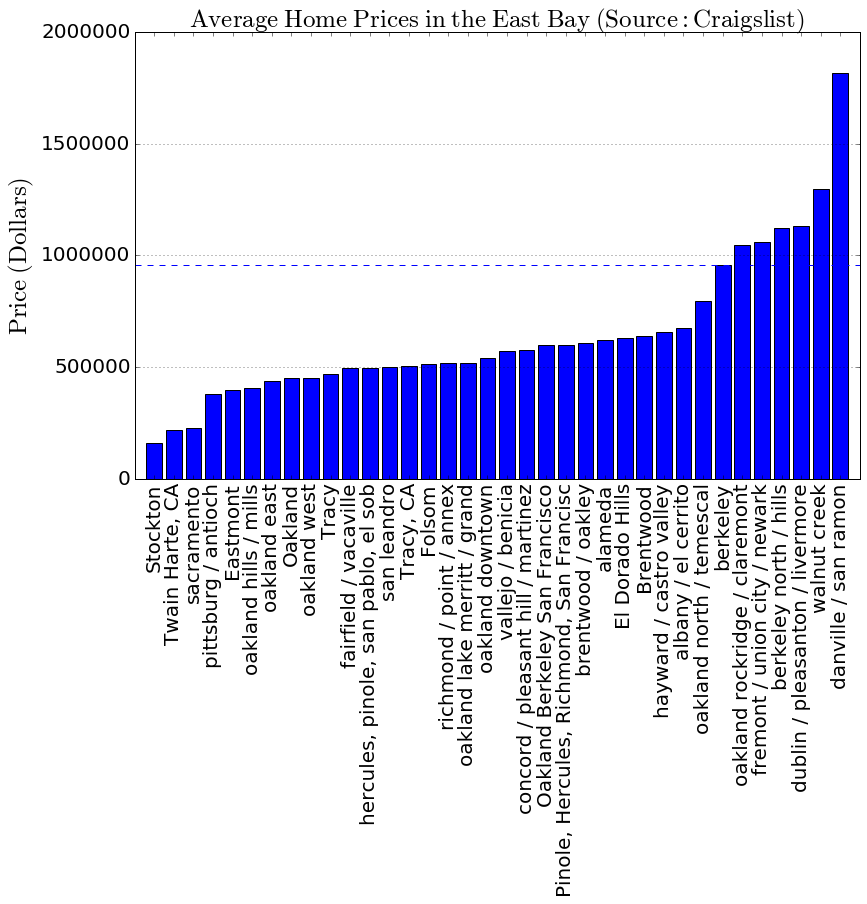

In [79]:
# Home prices in the East Bay

# Group the results by neighborhood, and then take the average home price in each neighborhood
by_neighborhood = alldata.groupby('Neighborhood').Price.mean().ix[neighborhoodsplt]
by_neighborhood_sort_price = by_neighborhood.sort_values(ascending = True) # uncomment
by_neighborhood_sort_price.index # a list of the neighborhoods sorted by price

# Plot average home price for each neighborhood in the East Bay
fig = plt.figure()
fig.set_figheight(8.0)
fig.set_figwidth(13.0)

fntsz=20
titlefntsz=25
lablsz=20
mrkrsz=8

matplotlib.rc('xtick', labelsize = lablsz); matplotlib.rc('ytick', labelsize = lablsz)

ax = fig.add_subplot(111) # row column position 

# Plot a bar chart
ax.bar(range(len(by_neighborhood_sort_price.index)), by_neighborhood_sort_price, align='center')

# Add a horizontal line for Berkeley's average home price, corresponds with Berkeley bar
ax.axhline(y=by_neighborhood.ix['berkeley'], linestyle='--')

# Add a grid
ax.grid(b = True, which='major', axis='y') # which='major','both'; options/kwargs: color='r', linestyle='-', linewidth=2)

# Format x axis
ax.set_xticks(range(0,len(by_neighborhood))); 
ax.set_xticklabels(by_neighborhood_sort_price.index, rotation='vertical') # 90, 45, 'vertical'
ax.set_xlim(-1, len(by_neighborhood_sort_price.index))

# Format y axis
ax.set_ylabel('$\mathrm{Price \; (Dollars)}$', fontsize = titlefntsz) # in Hundreds of Thousands of Dollars

# Set figure title
ax.set_title('$\mathrm{Average \; Home \; Prices \; in \; the \; East \; Bay \; (Source: Craigslist)}$', fontsize = titlefntsz)

# Save figure
#plt.savefig("home_prices.pdf",bbox_inches='tight')


## Regression

In [123]:
import statsmodels.formula.api as smf
import statsmodels.tools.eval_measures as smte

In [126]:
# Normalize square feet
# Normalized start_timestamp
alldata['SqFeet_norm'] = (alldata.SqFeet - alldata.SqFeet.mean())/alldata.SqFeet.std()

In [129]:
print(alldata.SqFeet_norm.min(), alldata.SqFeet_norm.max())

-0.5340392590664246 24.67145266221028


In [125]:
# OLS Multivariate Linear Regression Model
lm = smf.ols(formula='Price ~ SqFeet + nBedrooms', data=alldata).fit()

# Print the coefficients
print(lm.params, '\n')

# Print a summary of the fitted model
lm.summary()

# Coefficients:
# Intercept    
#    
#       

Intercept   -524433.046573
SqFeet           24.993184
nBedrooms    378717.265300
dtype: float64 



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     190.8
Date:                Thu, 07 Apr 2016   Prob (F-statistic):           1.80e-69
Time:                        17:59:37   Log-Likelihood:                -12893.
No. Observations:                 877   AIC:                         2.579e+04
Df Residuals:                     874   BIC:                         2.581e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -5.244e+05   8.49e+04     -6.175      0.000     -6.91e+05 -3.58e+05
SqFeet        24.9932      3.961      6.310      0.000        17.219    32.767
nBedrooms   3.787e+05   2.19e+04     17.273      0.000      3.36e+05  4.22e+05
==============================================================================
Omnibus:                      322.644   Durbin-Watson:                   1.748
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2661.670
Skew:                           1.442   Prob(JB):                         0.00
Kurtosis:                      11.032   Cond. No.                     2.54e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
lm.summary()

In [130]:
# OLS Multivariate Linear Regression Model
lm1 = smf.ols(formula='Price ~ SqFeet_norm + nBedrooms', data=alldata).fit()

# Print the coefficients
print(lm1.params, '\n')

# Print a summary of the fitted model
lm1.summary()  

Intercept     -458974.376549
SqFeet_norm    122104.764915
nBedrooms      378717.265300
dtype: float64 



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     190.8
Date:                Thu, 07 Apr 2016   Prob (F-statistic):           1.80e-69
Time:                        18:07:47   Log-Likelihood:                -12893.
No. Observations:                 877   AIC:                         2.579e+04
Df Residuals:                     874   BIC:                         2.581e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    -4.59e+05   8.58e+04     -5.347      0.000     -6.27e+05 -2.91e+05
SqFeet_norm  1.221e+05   1.94e+04      6.310      0.000      8.41e+04   1.6e+05
nBedrooms    3.787e+05   2.19e+04     17.273      0.000      3.36e+05  4.22e+05
==============================================================================
Omnibus:                      322.644   Durbin-Watson:                   1.748
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2661.670
Skew:                           1.442   Prob(JB):                         0.00
Kurtosis:                      11.032   Cond. No.                         18.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [133]:
# How to deal with outliers?
# How to improve Rsquared and predictive power?
# Also how to force the intercept to be at zero or at least positive (because Price can't be negative)


In [134]:
# Model predictions
# predict_price = intercept + coeff_SqFeet*X_SqFeet + coeff_nBedrooms*X_nBedrooms
predict_price = lm.params[0] + lm.params[1]*alldata.SqFeet + lm.params[2]*alldata.nBedrooms

In [136]:
predict_price[0:5]

0               NaN
1               NaN
2    1447206.993598
3    1471250.436618
4    1059367.216133
dtype: float64

In [135]:
# Calc. mean absolute error of predicted vs. actual durations (how the soln will be assessed)

#import statsmodels.tools.eval_measures as smte
MAE = smte.meanabs(alldata.Price, predict_price)
print(MAE)

nan


(0, 4000)

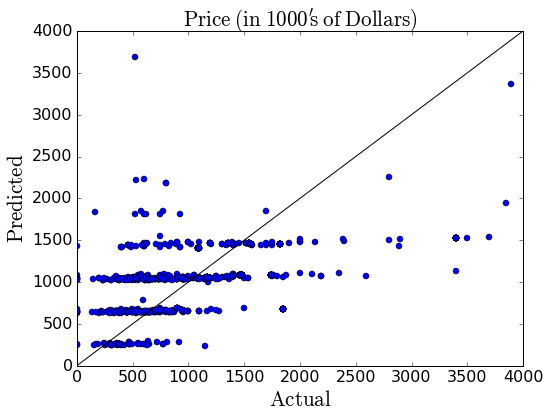

In [155]:
# Plot 
fig = plt.figure(figsize(8,6))
numsz = 16
ftsz = 21

ax = fig.add_subplot(111)
ax.plot(alldata.Price/1000, predict_price/1000, 'bo')
ax.plot(np.arange(0, alldata.Price.max()/1000), np.arange(0,alldata.Price.max()/1000), 'k-')
ax.tick_params(axis='both', labelsize = numsz)
ax.set_xlabel('$\mathrm{Actual}$', fontsize = ftsz)
ax.set_ylabel('$\mathrm{Predicted}$', fontsize = ftsz)
ax.set_title('$\mathrm{Price \; (in \; 1000\'s \; of \; Dollars)}$', fontsize = ftsz)
ax.set_xlim(0,4000)
ax.set_ylim(0,4000)

In [ ]:
X = alldata.Price
Y = alldata.Price/1000 # in 1000's of Dollars
labels = ['$\mathrm{Number \; of \; Bedrooms}$', '$\mathrm{Price \; (in \; 1000\'s \; of \; Dollars)}$']
ax = scatterplot(X,Y,labels)

In [158]:
# All data:
print(len(alldata), '\n')
print(alldata.dtypes, '\n')
#print(alldata.head(5))

1100 

Price                  float64
SqFeet                 float64
nBedrooms              float64
DatePosted      datetime64[ns]
Neighborhood            object
SqFeet_norm            float64
dtype: object 



## Group results by neighborhood and plot

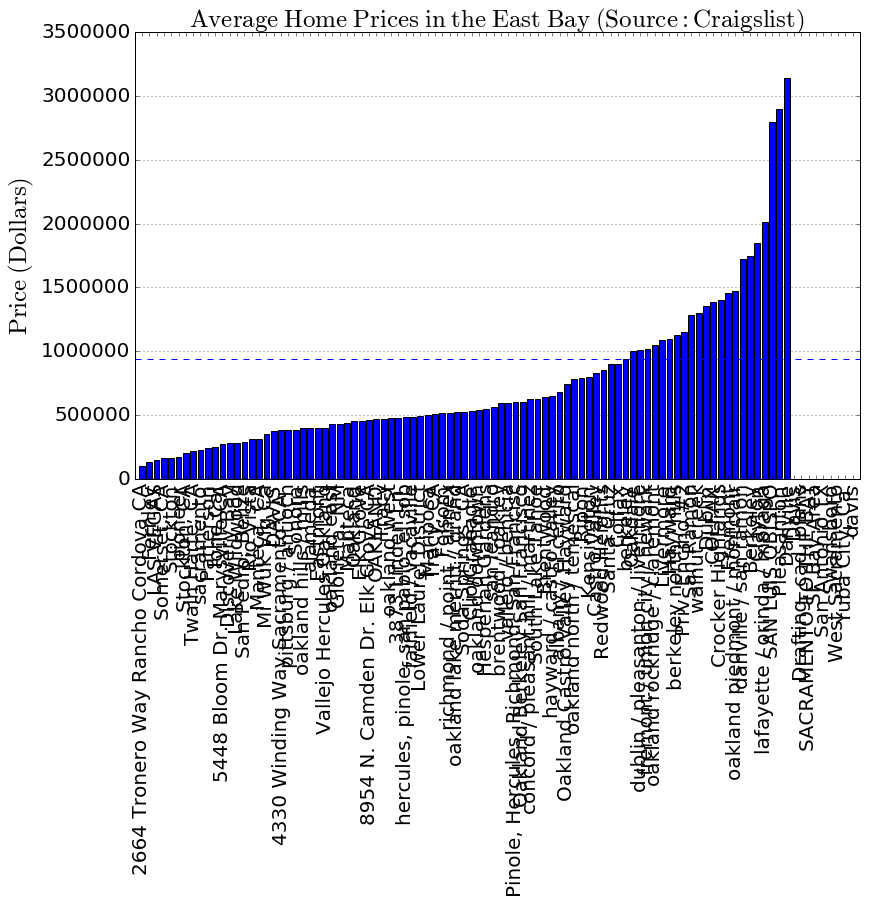

In [55]:
# * Home prices in the East Bay *

# Group the results by neighborhood, and then take the average home price in each neighborhood
by_neighborhood = alldata.groupby('Neighborhood').mean().Price
by_neighborhood_sort_price = by_neighborhood.sort_values(ascending = True) # uncomment
by_neighborhood_sort_price.index # a list of the neighborhoods sorted by price

# Plot average home price for each neighborhood in the East Bay
fig = plt.figure()
fig.set_figheight(8.0)
fig.set_figwidth(13.0)
# fig = plt.figure(figsize=(15,8)) # or more compact version, width, height

fntsz=20
titlefntsz=25
lablsz=20
mrkrsz=8

matplotlib.rc('xtick', labelsize = lablsz); matplotlib.rc('ytick', labelsize = lablsz)

ax = fig.add_subplot(111) # row column position 

# Plot a bar chart
ax.bar(range(len(by_neighborhood_sort_price.index)), by_neighborhood_sort_price, align='center')

# Add a horizontal line for Berkeley's average home price, corresponds with Berkeley bar
ax.axhline(y=by_neighborhood.ix['berkeley'], linestyle='--')

# Add a grid
ax.grid(b = True, which='major', axis='y') # which='major','both'; options/kwargs: color='r', linestyle='-', linewidth=2)

# Format x axis
ax.set_xticks(range(0,len(by_neighborhood))); 
ax.set_xticklabels(by_neighborhood_sort_price.index, rotation='vertical') # 90, 45, 'vertical'
ax.set_xlim(-1, len(by_neighborhood_sort_price.index))

# Format y axis
#minor_yticks  = np.arange(0, 1600000, 100000)
#ax.set_yticks(minor_yticks, minor = True) 
ax.set_ylabel('$\mathrm{Price \; (Dollars)}$', fontsize = titlefntsz) # in Hundreds of Thousands of Dollars

# Set figure title
ax.set_title('$\mathrm{Average \; Home \; Prices \; in \; the \; East \; Bay \; (Source: Craigslist)}$', fontsize = titlefntsz)
#fig.suptitle('Home Prices in the East Bay (Source: Craigslist)')

# Save figure
#plt.savefig("home_prices.pdf",bbox_inches='tight')


In [ ]:
# 1)
# Specify list of neighborhoods I want to plot
# and only plot those
# or only plot neighborhoods with count greater than 1 (better) to drop
# addresses misfiled in neighborhoods section

# 2)
# Price in 1,000's of Dollars for Plot

## Group results and plot

In [173]:
by_neighborhood = housesdfAll.groupby('Neighborhood')
print(by_neighborhood.count())#.head()) # NOT NULL records within each column
print('\n')
print(by_neighborhood.size())#.head()) # total records for each neighborhood

#by_neighborhood.Neighborhood.nunique()

                                     Price  SqFeet  nBedrooms  DatePosted
Neighborhood                                                             
1014 Pine Meadow Ct                      1       1          1           1
4900 Kellogg Rd. Sutter CA               1       1          1           1
6633 Piper Rd.                           1       1          1           1
8954 N. Camden Dr. Elk Grove CA          2       2          2           2
COLFAX                                   1       1          1           1
Central Stockton                         1       1          1           1
Clayton                                  3       1          1           3
Clio/Graeagle                            1       1          1           1
Columbia, CA                             1       0          0           1
Creston                                  2       2          2           2
Donner Lake                              1       1          1           1
Drafting, cad, plans                  

In [425]:
#housesdfAll['Price'] = housesdfAll['Price'].astype(float)
#housesdfAll['Neighborhood'] = housesdfAll['Neighborhood'].astype(str)

#pd.to_numeric(housesdfAll['Price'])
#print(type(housesdfAll.Price[0]))

In [183]:
# Descriptive statistics

#print(by_neighborhood['Price'].count()) 
#print('\n')

print(by_neighborhood['Price'].mean().head()) 
print('\n')

#print(by_neighborhood['Price'].min()) 
#print('\n')

#print(by_neighborhood['Price'].max()) 

Neighborhood
1014 Pine Meadow Ct                 697500
4900 Kellogg Rd. Sutter CA          655000
6633 Piper Rd.                        1900
8954 N. Camden Dr. Elk Grove CA     465000
COLFAX                             1389000
Name: Price, dtype: float64




In [184]:
print(len(housesdfAll.index)) # total #rows
print(len(set(housesdfAll.Neighborhood))) # #unique neighborhoods
set(housesdfAll.Neighborhood) # list the #unique neighborhoods

500
75


{nan,
 'HAYWARD',
 'dublin / pleasanton / livermore',
 'oakland west',
 'Oakdale',
 'Elk Grove, CA',
 'berkeley',
 '1014 Pine Meadow Ct',
 'Mi Wuk Vlg Ca',
 '6633 Piper Rd.',
 'Oakdale, CA',
 'Clayton',
 'danville / san ramon',
 'Pittsburgh, PA',
 'San Lorenzo',
 'brentwood / oakley',
 'berkeley north / hills',
 'Clio/Graeagle',
 'oakland north / temescal',
 '8954 N. Camden Dr. Elk Grove CA',
 'Glorieta, NM',
 'san leandro',
 'walnut creek',
 'fremont / union city / newark',
 'Donner Lake',
 'Hercules',
 'oakland hills / mills',
 'Columbia, CA',
 'South Lake Tahoe',
 'albany / el cerrito',
 'Laurel District',
 'Lathrop',
 'Oakland',
 'Sonora, CA',
 'Tracy, CA',
 'concord / pleasant hill / martinez',
 'pittsburg / antioch',
 'Tracy',
 'Drafting, cad, plans',
 'Soda Springs, CA',
 'Escalon Ca.',
 'oakland east',
 'davis',
 'oakland piedmont / montclair',
 'richmond / point / annex',
 'Lake Wildwood',
 'Porterville',
 'Paso Robles',
 'San Francisco',
 'Stockton, CA',
 'Modesto',
 'FRESNO'

In [ ]:
# To do:
# Make bar chart with price ranges 
# (<500,000; 500,000 to 750,000; 750,000 to 1,000,000; 1M to 1.5M; 1.5M to 2 M; >2M)
# Do a predictive model example to show I can implement it (even though not enough data) 
# to predict house price based on square feet (first irregardless of neighborhood)

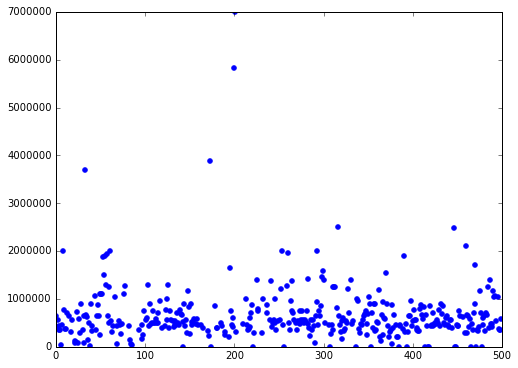

In [185]:
# Quick plot all data to take a look
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111) # row column position 
ax.plot(housesdfAll.Price, '.', markersize=10) #x,y1,'b-',label="",linewidth=1)

#ax.set_title('Title')
#ax.set_xlabel('x')
#ax.set_ylabel('y')
#ax.legend()

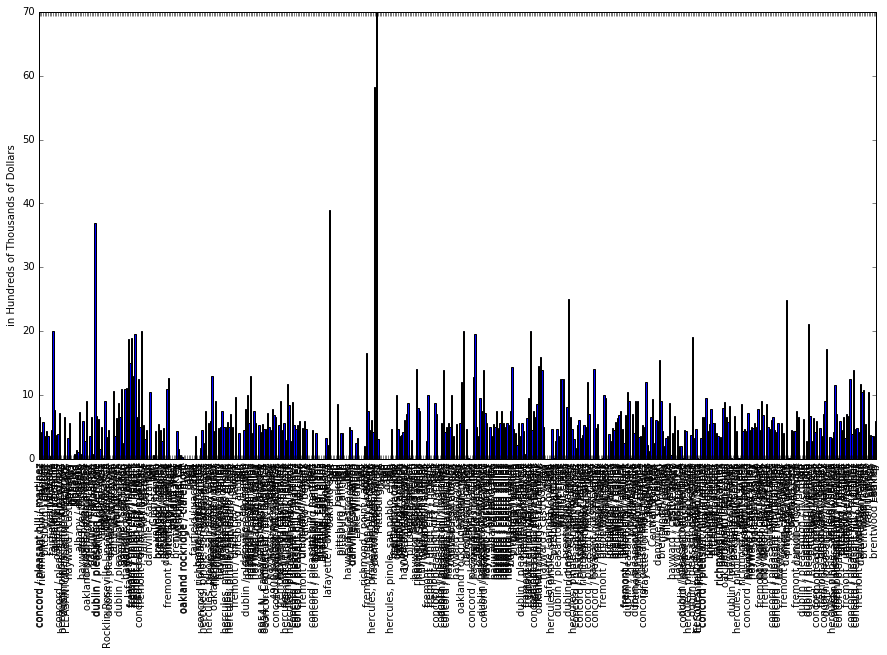

In [186]:
# Same as above: quick plot all data to take a look

plt.figure(figsize=(15,8))

plt.xticks(range(len(housesdfAll.index)), housesdfAll.Neighborhood, rotation='vertical'); # 90, 45, 'vertical'

plt.bar(range(len(housesdfAll.index)), housesdfAll.Price/100000, align='center')

ylabel('in Hundreds of Thousands of Dollars')

In [ ]:
# Troubleshooting
# commas in y axis
# '{:20,d}'.format(1000)

#ax.get_yaxis().set_major_formatter( ticker.FuncFormatter(lambda x, pos: str(x).replace('.',',')) ) 

#ax.get_yaxis().set_major_formatter(
#    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

ValueError: could not convert string to float: 'walnut creek'

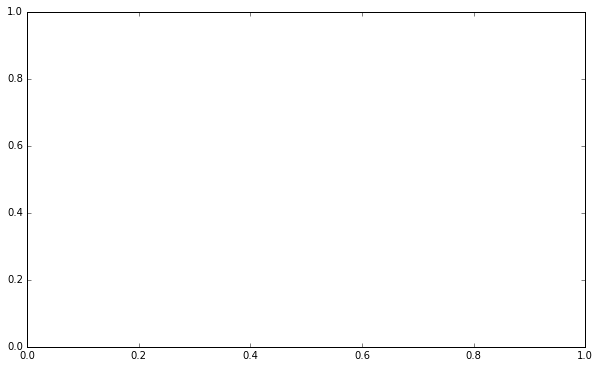

In [188]:
# Quick plot all data grouped by neighborhood to take a look
fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(10.0)

ax = fig.add_subplot(111) # row column position 

# or shortcut: fig, ax1 = plt.subplots()b

ax.plot(by_neighborhood['Price'].mean(),'bo')#, label = by_neighborhood.Neighborhood)# by_neighborhood['neighborhood'] ,markersize=mrkrsz) # 'ro')
#errorbar(heightCount,dataAllNormalizedStatsHeight.ix[:,0],yerr=dataAllNormalizedStatsHeight.ix[:,1],color='blue',linestyle='none')      

#plt.xticks(arange(7),('','$\mathrm{1.3}$','$\mathrm{1.4}$','$\mathrm{1.5}$','$\mathrm{1.6}$','$\mathrm{1.7}$',''),fontsize=fntsz)
#ax.set_xlabel('$\mathrm{Height \: (meters)}$')#,fontsize=fntsz)
#ax.set_ylabel('$\mathrm{Ave \: CO \: / \: CO_{well-mixed} \: for \: all \: locations}$')#,fontsize=fntsz)
#ax.legend()#by_neighborhood['neighborhood'])
#ax1.set_yticks(major_yticks)
#ax1.set_yticks(minor_yticks, minor = True)
#ylim((1.0,2.5))
#plt.savefig("door_d100_nCOave_h.pdf",bbox_inches='tight')
#show()

In [189]:
testberkeley = housesdfAll[housesdfAll['Neighborhood'] == 'berkeley']
testberkeley

,Price,SqFeet,nBedrooms,DatePosted,Neighborhood
178,855000,1690,3,2016-02-04 00:24:00,berkeley
197,450000,NaN,NaN,2016-02-03 19:42:00,berkeley
412,825000,NaN,3,2016-02-01 14:02:00,berkeley


In [191]:
print('{0:8,.0f}'.format(testberkeley.mean().Price))
print('{0:8,.0f}'.format(testberkeley.max().Price))
print('{0:8,.0f}'.format(testberkeley.min().Price))

 710,000
 855,000
 450,000


In [193]:
print('{0:8,.0f}'.format(housesdfAll.groupby('Neighborhood').mean().Price.ix['berkeley']))
print('{0:8,.0f}'.format(housesdfAll.groupby('Neighborhood').max().Price.ix['berkeley']))
print('{0:8,.0f}'.format(housesdfAll.groupby('Neighborhood').min().Price.ix['berkeley']))

 710,000
 855,000
 450,000


In [198]:
# Troubleshooting
which_neighborhood = housesdfAll.groupby('Neighborhood').mean().max() #.max().index
print(which_neighborhood)

#test = by_neighborhood['Neighborhood']# = which_neighborhood].index#.index
#print(test)

Price        2146624.75
SqFeet         18054.00
nBedrooms          6.00
dtype: float64


In [200]:
# Check: keep for reference
by_neighborhood = housesdfAll.groupby('Neighborhood').mean().Price # by_neighborhood_mean_price
print(by_neighborhood.head(5), '\n')
print(by_neighborhood['Twain Harte, CA'], '\n') 
print(by_neighborhood.index, '\n') 

by_neighborhood_sort_price = by_neighborhood.sort_values(ascending = True)
print(by_neighborhood_sort_price.index)
print(by_neighborhood_sort_price)

Neighborhood
1014 Pine Meadow Ct                 697500
4900 Kellogg Rd. Sutter CA          655000
6633 Piper Rd.                        1900
8954 N. Camden Dr. Elk Grove CA     465000
COLFAX                             1389000
Name: Price, dtype: float64 

184000.0 

Index(['1014 Pine Meadow Ct', '4900 Kellogg Rd. Sutter CA', '6633 Piper Rd.',
       '8954 N. Camden Dr. Elk Grove CA', 'COLFAX', 'Central Stockton',
       'Clayton', 'Clio/Graeagle', 'Columbia, CA', 'Creston', 'Donner Lake',
       'Drafting, cad, plans', 'Dublin', 'El Sobrante 7.5 miles from Orinda',
       'Elk Grove, CA', 'Escalon Ca.', 'FRESNO', 'Glorieta, NM', 'HAYWARD',
       'Hayward Hills', 'Hercules', 'Lake Wildwood', 'Lathrop',
       'Laurel District', 'Loomis', 'Mi Wuk Vlg Ca', 'Modesto', 'Morro Bay',
       'Oakdale', 'Oakdale, CA', 'Oakland', 'PLEASANTON-DUBLIN-LIVERMORE',
       'Paso Robles', 'Pittsburgh, PA', 'Porterville',
       'Rocklin,Roseville,Lincoln,Granite Bay', 'San Diego', 'San Francisco',
 

In [201]:
# Home prices in Berkeley
print('The average home price in Berkeley is: $', '{0:8,.0f}'.format(housesdfAll.groupby('Neighborhood').mean().Price.ix['berkeley']), '\n')
print('The most expensive home price in Berkeley is:  $', '{0:8,.0f}'.format(housesdfAll.groupby('Neighborhood').max().Price.ix['berkeley']), '\n')
print('The least expensive home price in Berkeley is: $', '{0:9,.0f}'.format(housesdfAll.groupby('Neighborhood').min().Price.ix['berkeley']), '\n')

#print('The "cheapest" home price is in: ', results.groupby('neighborhood').mean().price.ix['berkeley'], '\n')
#print('The most expensive home price is in: ', results.groupby('neighborhood').mean().price.ix['berkeley'], '\n')

# Other versions of print statements
# print('Average home price in Berkeley: %8.0f' %results.groupby('neighborhood').mean().price.ix['berkeley'])
# print ["{0:0.2f}".format(i) for i in a] #print("{0:,g}".format(number))

The average home price in Berkeley is: $  710,000 

The most expensive home price in Berkeley is:  $  855,000 

The least expensive home price in Berkeley is: $   450,000 



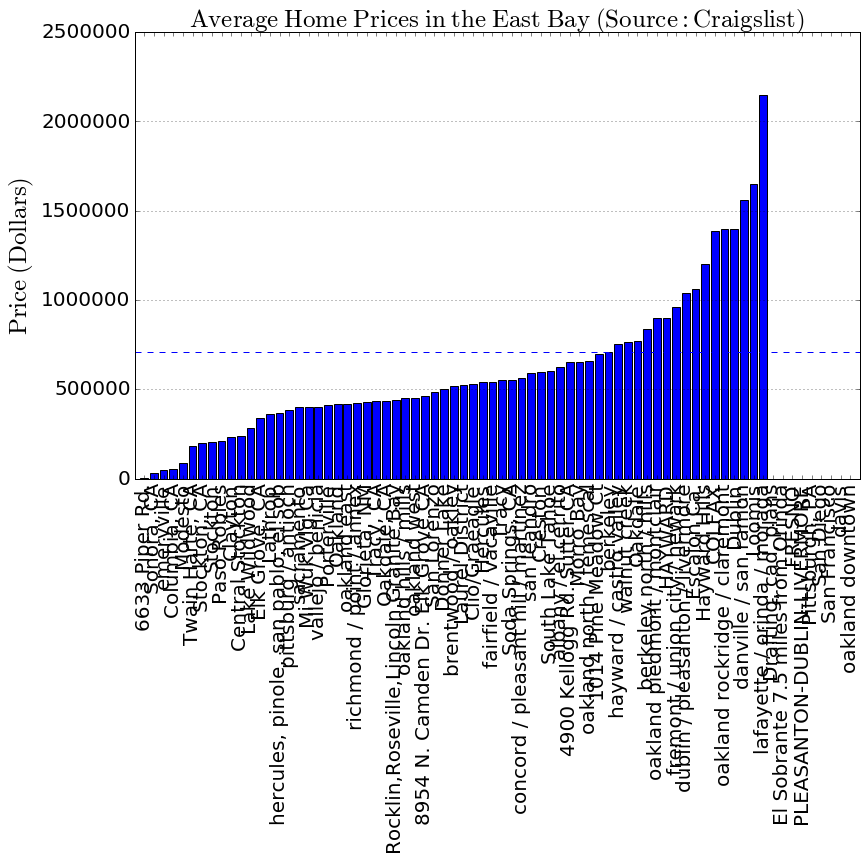

In [203]:
# * Home prices in the East Bay *

# Group the results by neighborhood, and then take the average home price in each neighborhood
#by_neighborhood = results.groupby('neighborhood').mean().price # uncomment
#by_neighborhood_sort_price = by_neighborhood.sort_values(ascending = True) # uncomment
# by_neighborhood_sort_price.index # a list of the neighborhoods sorted by price

# Plot average home price for each neighborhood in the East Bay
fig = plt.figure()
fig.set_figheight(8.0)
fig.set_figwidth(13.0)
# fig = plt.figure(figsize=(15,8)) # or more compact version, width, height

fntsz=20
titlefntsz=25
lablsz=20
mrkrsz=8

matplotlib.rc('xtick', labelsize = lablsz); matplotlib.rc('ytick', labelsize = lablsz)

ax = fig.add_subplot(111) # row column position 

# Plot a bar chart
ax.bar(range(len(by_neighborhood_sort_price.index)), by_neighborhood_sort_price, align='center')

# Add a horizontal line for Berkeley's average home price, corresponds with Berkeley bar
ax.axhline(y=housesdfAll.groupby('Neighborhood').mean().Price.ix['berkeley'], linestyle='--')

# Add a grid
ax.grid(b = True, which='major', axis='y') # which='major','both'; options/kwargs: color='r', linestyle='-', linewidth=2)

# Format x axis
ax.set_xticks(range(0,len(housesdfAll.groupby('Neighborhood').mean().Price))); 
ax.set_xticklabels(by_neighborhood_sort_price.index, rotation='vertical') # 90, 45, 'vertical'
ax.set_xlim(-1, len(by_neighborhood_sort_price.index))

# Format y axis
#minor_yticks  = np.arange(0, 1600000, 100000)
#ax.set_yticks(minor_yticks, minor = True) 
ax.set_ylabel('$\mathrm{Price \; (Dollars)}$', fontsize = titlefntsz) # in Hundreds of Thousands of Dollars

# Set figure title
ax.set_title('$\mathrm{Average \; Home \; Prices \; in \; the \; East \; Bay \; (Source: Craigslist)}$', fontsize = titlefntsz)
#fig.suptitle('Home Prices in the East Bay (Source: Craigslist)')

# Save figure
#plt.savefig("home_prices.pdf",bbox_inches='tight')



In [214]:
# Neighborhoods of Interest to Plot
NOI = ['albany / el cerrito',
 'berkeley',
 'berkeley north / hills',
 'brentwood / oakley',
 'concord / pleasant hill / martinez',
 'danville / san ramon',
 'dublin / pleasanton / livermore',
 'El Sobrante 7.5 miles from Orinda',
 'emeryville',
 'fairfield / vacaville',
 'fremont / union city / newark',
 'hayward / castro valley',
 'hercules, pinole, san pablo, el sob',
 'lafayette / orinda / moraga',
 'oakland downtown',
 'oakland east',
 'oakland hills / mills',
 'oakland north / temescal',
 'oakland piedmont / montclair',
 'oakland rockridge / claremont',
 'oakland west',
 'pittsburg / antioch',
 'richmond / point / annex',
 'sacramento',
 'san leandro',
 'vallejo / benicia',
 'walnut creek']

In [221]:
housesdfAll[housesdfAll['Neighborhood'] == NOI[0]]

,Price,SqFeet,nBedrooms,DatePosted,Neighborhood
24,729000,NaN,3,2016-02-05 10:36:00,albany / el cerrito
198,600000,NaN,NaN,2016-02-03 19:33:00,albany / el cerrito
271,549000,NaN,2,2016-02-03 11:04:00,albany / el cerrito
411,575000,NaN,2,2016-02-01 14:05:00,albany / el cerrito
483,675000,860,2,2016-01-30 20:32:00,albany / el cerrito


In [225]:
housesdfAll.groupby('Neighborhood')[['Neighborhood'] in NOI]

KeyError: 'Column not found: False'

In [ ]:
# * Home prices in the East Bay *

# Group the results by neighborhood, and then take the average home price in each neighborhood
#by_neighborhood = results.groupby('neighborhood').mean().price # uncomment
#by_neighborhood_sort_price = by_neighborhood.sort_values(ascending = True) # uncomment
# by_neighborhood_sort_price.index # a list of the neighborhoods sorted by price

# Plot average home price for each neighborhood in the East Bay
fig = plt.figure()
fig.set_figheight(8.0)
fig.set_figwidth(13.0)
# fig = plt.figure(figsize=(15,8)) # or more compact version, width, height

fntsz=20
titlefntsz=25
lablsz=20
mrkrsz=8

matplotlib.rc('xtick', labelsize = lablsz); matplotlib.rc('ytick', labelsize = lablsz)

ax = fig.add_subplot(111) # row column position 

# Plot a bar chart
ax.bar(range(len(by_neighborhood_sort_price.index)), by_neighborhood_sort_price, align='center')

# Add a horizontal line for Berkeley's average home price, corresponds with Berkeley bar
ax.axhline(y=housesdfAll.groupby('Neighborhood').mean().Price.ix['berkeley'], linestyle='--')

# Add a grid
ax.grid(b = True, which='major', axis='y') # which='major','both'; options/kwargs: color='r', linestyle='-', linewidth=2)

# Format x axis
ax.set_xticks(range(0,len(housesdfAll.groupby('Neighborhood').mean().Price))); 
ax.set_xticklabels(by_neighborhood_sort_price.index, rotation='vertical') # 90, 45, 'vertical'
ax.set_xlim(-1, len(by_neighborhood_sort_price.index))

# Format y axis
#minor_yticks  = np.arange(0, 1600000, 100000)
#ax.set_yticks(minor_yticks, minor = True) 
ax.set_ylabel('$\mathrm{Price \; (Dollars)}$', fontsize = titlefntsz) # in Hundreds of Thousands of Dollars

# Set figure title
ax.set_title('$\mathrm{Average \; Home \; Prices \; in \; the \; East \; Bay \; (Source: Craigslist)}$', fontsize = titlefntsz)
#fig.suptitle('Home Prices in the East Bay (Source: Craigslist)')

# Save figure
#plt.savefig("home_prices.pdf",bbox_inches='tight')


In [ ]:
# Group the results by neighborhood, and then take the average home price in each neighborhood
# by_neighborhood = results.groupby('neighborhood').mean().price
# by_neighborhood_sort_price = by_neighborhood.sort_values(ascending = True)
# by_neighborhood_sort_price.index # a list of the neighborhoods sorted by price

# Check
#by_neighborhood = results.groupby('neighborhood').mean().price # by_neighborhood_mean_price
#print(by_neighborhood.head(5), '\n')
#print(by_neighborhood['Twain Harte, CA'], '\n') 
#print(by_neighborhood.index, '\n') 

#by_neighborhood_sort_price = by_neighborhood.sort_values(ascending = True)
#print(by_neighborhood_sort_price.index)
#print(by_neighborhood_sort_price)

In [704]:
print(arange(len(by_neighborhood_sort_price.index)))
print(arange(len(by_neighborhood_sort_price.index)).size)
print(by_neighborhood_sort_price.index.size) # 29 values in index
#print('\n'.join(by_neighborhood_sort_price.index))
print()

range(len(by_neighborhood_sort_price.index)) # doesn't include last value

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
29
29



range(0, 29)

The average home price in Berkeley is: $ 1,050,767 

The most expensive home price in Berkeley is:  $ 1,799,000 

The least expensive home price in Berkeley is: $     3,300 



(-1, 29)

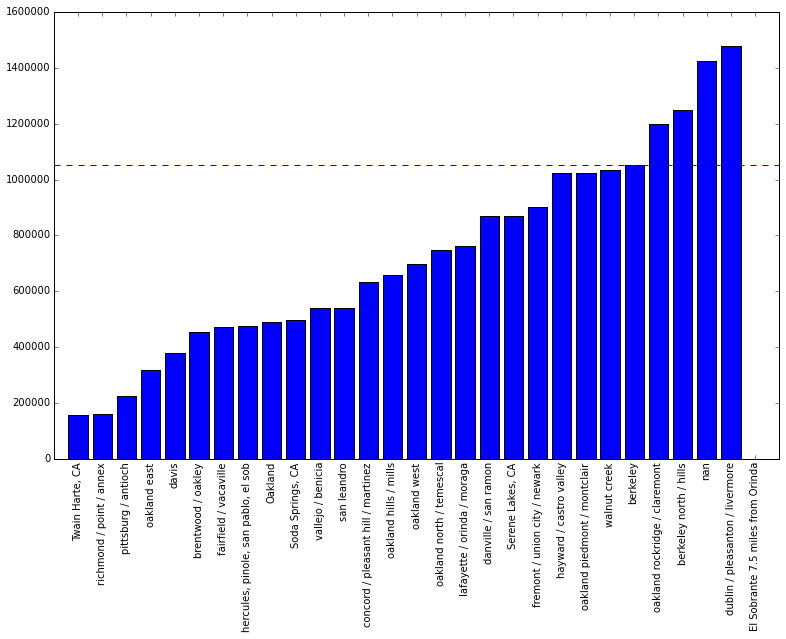

In [710]:
# Also works

# Group the results by neighborhood, and then take the average home price in each neighborhood
by_neighborhood = results.groupby('neighborhood').mean().price
by_neighborhood_sort_price = by_neighborhood.sort_values(ascending = True)
# by_neighborhood_sort_price.index # a list of the neighborhoods sorted by price

# Summarize home prices in Berkeley
print('The average home price in Berkeley is: $', '{0:8,.0f}'.format(results.groupby('neighborhood').mean().price.ix['berkeley']), '\n')
print('The most expensive home price in Berkeley is:  $', '{0:8,.0f}'.format(results.groupby('neighborhood').max().price.ix['berkeley']), '\n')
print('The least expensive home price in Berkeley is: $', '{0:9,.0f}'.format(results.groupby('neighborhood').min().price.ix['berkeley']), '\n')

# Plot average home price for each neighborhood in the East Bay
plt.figure(figsize=(13,8))

#plt.xticks(range(len(results.groupby('neighborhood').mean().index)), by_neighborhood_sort_price.index, rotation='vertical') # 90, 45, 'vertical'

#plt.bar(range(len(by_neighborhood_sort_price.index)), by_neighborhood_sort_price, align = 'center')
plt.bar(arange(len(by_neighborhood_sort_price.index)), by_neighborhood_sort_price, align = 'center')



# Berkeley is horizontal line, corresponds with Berkeley bar
plt.axhline(y=results.groupby('neighborhood').mean().price.ix['berkeley'], linestyle = '--')
#plt.xticks(range(len(by_neighborhood_sort_price.index)))
#plt.xticks?
#plt.xlabel(by_neighborhood_sort_price.index, rotation='vertical') # 90, 45, 'vertical'

# set the locations and labels of the xticks
plt.xticks(arange(len(by_neighborhood_sort_price.index)), by_neighborhood_sort_price.index, rotation = 90);
plt.xlim(-1, len(by_neighborhood_sort_price.index))
#ylabel('in Hundreds of Thousands of Dollars')


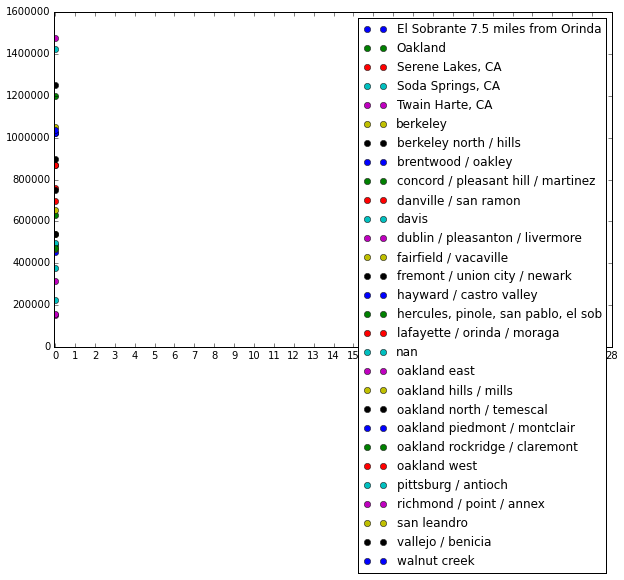

In [487]:
# 
fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(10.0)

ax = fig.add_subplot(111) # row column position 

for n in range(0,len(results.groupby('neighborhood').mean().price)):
    ax.plot(results.groupby('neighborhood').mean().price[n], 'o', label = results.groupby('neighborhood').mean().index[n])# by_neighborhood['neighborhood'] ,markersize=mrkrsz) # 'ro')
#errorbar(heightCount,dataAllNormalizedStatsHeight.ix[:,0],yerr=dataAllNormalizedStatsHeight.ix[:,1],color='blue',linestyle='none')      
#ax.arrange(results.groupby('neighborhood').mean().index)
#ax.set_xticklabels
#ax.set_xticks
ax.set_xticks(arange(len(results.groupby('neighborhood').mean().index)))#,('', results.groupby('neighborhood').mean().index, ''))
#plt.xticks(arange(7),('','$\mathrm{1.3}$','$\mathrm{1.4}$','$\mathrm{1.5}$','$\mathrm{1.6}$','$\mathrm{1.7}$',''),fontsize=fntsz)
ax.legend()

In [467]:
print(results.groupby('neighborhood').mean().index[0], '\n')
results.groupby('neighborhood').mean().index

El Sobrante 7.5 miles from Orinda 



Index(['El Sobrante 7.5 miles from Orinda', 'Oakland', 'Serene Lakes, CA',
       'Soda Springs, CA', 'Twain Harte, CA', 'berkeley',
       'berkeley north / hills', 'brentwood / oakley',
       'concord / pleasant hill / martinez', 'danville / san ramon', 'davis',
       'dublin / pleasanton / livermore', 'fairfield / vacaville',
       'fremont / union city / newark', 'hayward / castro valley',
       'hercules, pinole, san pablo, el sob', 'lafayette / orinda / moraga',
       'nan', 'oakland east', 'oakland hills / mills',
       'oakland north / temescal', 'oakland piedmont / montclair',
       'oakland rockridge / claremont', 'oakland west', 'pittsburg / antioch',
       'richmond / point / annex', 'san leandro', 'vallejo / benicia',
       'walnut creek'],
      dtype='object', name='neighborhood')

In [457]:
#df.groupby('E').sum().D
results.groupby('neighborhood').mean().price

neighborhood
El Sobrante 7.5 miles from Orinda                 NaN
Oakland                                 488888.000000
Serene Lakes, CA                        870000.000000
Soda Springs, CA                        497500.000000
Twain Harte, CA                         154500.000000
berkeley                               1050766.666667
berkeley north / hills                 1250000.000000
brentwood / oakley                      452454.857143
concord / pleasant hill / martinez      632600.000000
danville / san ramon                    869900.000000
davis                                   379500.000000
dublin / pleasanton / livermore        1478835.714286
fairfield / vacaville                   470000.000000
fremont / union city / newark           900525.111111
hayward / castro valley                1022400.000000
hercules, pinole, san pablo, el sob     474981.333333
lafayette / orinda / moraga             761242.000000
nan                                    1425208.000000
oakland east   

In [459]:
results.groupby('neighborhood').max().price
results.groupby('neighborhood').min().price

neighborhood
El Sobrante 7.5 miles from Orinda          NaN
Oakland                                 488888
Serene Lakes, CA                        870000
Soda Springs, CA                        345000
Twain Harte, CA                          90000
berkeley                                  3300
berkeley north / hills                 1250000
brentwood / oakley                      299900
concord / pleasant hill / martinez      480000
danville / san ramon                    869900
davis                                   379500
dublin / pleasanton / livermore         525000
fairfield / vacaville                   305000
fremont / union city / newark           600000
hayward / castro valley                 549000
hercules, pinole, san pablo, el sob       2500
lafayette / orinda / moraga             761242
nan                                     811995
oakland east                            275000
oakland hills / mills                   619000
oakland north / temescal                699000
